In [3]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments') ,
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Muley123@',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path =  r'C:\Users\idea\myfolder\archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64



In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Muley123@',
    database='ecommerce'
)
cursor = conn.cursor()
if cursor.nextset():
    cursor.fetchall() 




##  List all unique cities where customers are located.


In [15]:
query = """ select distinct customer_city from customers """
cursor.execute(query)
data=cursor.fetchall()
df = pd.DataFrame(data)
print(df)

                          0
0                    franca
1     sao bernardo do campo
2                 sao paulo
3           mogi das cruzes
4                  campinas
...                     ...
4114                 siriji
4115    natividade da serra
4116           monte bonito
4117             sao rafael
4118      eugenio de castro

[4119 rows x 1 columns]


Number of orders placed in 2018

In [17]:
query =""" select count(order_id) from orders where year(order_purchase_timestamp) =2018 """ 
cursor.execute(query)
data=cursor.fetchall()
"Total orders Placed in 2018 are " ,data[0][0]

('Total orders Placed in 2018 are ', 108022)

total sales per category

query =""" SELECT products.product_category, round(sum(payments.payment_value),2)
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY products.product_category;
""" 
cursor.execute(query)
data=cursor.fetchall()
df = pd.DataFrame(data,columns=['category','sales'])
print(df)

calaculate the percentage of order that were paid in emi

In [34]:
query =""" SELECT (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS percentage
FROM payments;
 """ 
cursor.execute(query)
data=cursor.fetchall()
data

[(Decimal('99.9981'),)]

## count the number of customer from each state


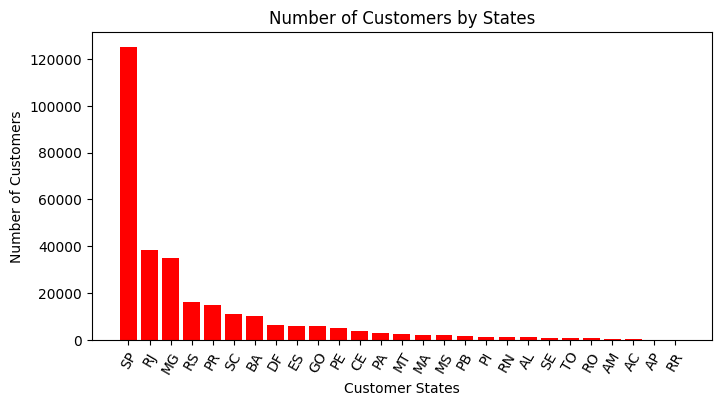

In [48]:
query=""" select customer_state , count(customer_id)
from customers group by customer_state """
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data , columns =['state','count'])
plt.figure(figsize=(8,4))
df = df.sort_values(by = "count", ascending= False)
plt.bar(df['state'],df['count'],color='red')
plt.xlabel('Customer States')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by States')
plt.xticks(rotation=60)
plt.show()

## Calculate the number of orders per month in 2018.

       Month  count
0       July  12584
1     August  13024
2   February  13456
3       June  12334
4      March  14422
5    January  14538
6        May  13746
7      April  13878
8  September     32
9    October      8


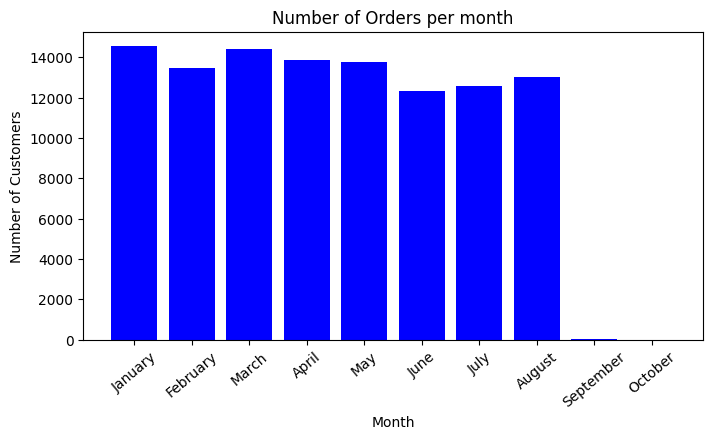

In [60]:
query=""" select monthname(order_purchase_timestamp) months,count(order_id)
from  orders where (order_purchase_timestamp) =2018
group by months"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data , columns =['Month','count'])
print(df)
plt.figure(figsize=(8,4))
o=["January", "February","March","April","May","June","July","August","September","October"]
df['Month'] = pd.Categorical(df['Month'], categories=o, ordered=True)
df = df.sort_values('Month')
plt.bar(df['Month'],df['count'],color='Blue' )
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.title('Number of Orders per month')
plt.xticks(rotation=40)
plt.show()

   

## calculate percentage of total revenue by each product category

In [62]:
query="""SELECT products.product_category, 
       ROUND((SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100, 2) AS percentage
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY products.product_category order by percentage desc;
"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data , columns =['category','percentage'])
df.head(10)


,category,percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


## find the average no. of products per order ,grouped by customer city  

In [67]:
query="""SELECT 
    customers.customer_city, 
    AVG(order_counts.product_count) AS avg_products_per_order
FROM customers
JOIN orders ON customers.customer_id = orders.customer_id
JOIN (
    SELECT 
        order_id, 
        COUNT(product_id) AS product_count
    FROM order_items
    GROUP BY order_id
) AS order_counts ON orders.order_id = order_counts.order_id
GROUP BY customers.customer_city;

"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data )
df.head(10)

,0,1
0,sao paulo,1.1562
1,urussanga,1.0000
2,macapa,1.1481
3,salvador,1.1405
4,itaquaquecetuba,1.0526
5,sao jose dos campos,1.1385
6,sao caetano do sul,1.1091
7,belo horizonte,1.1433
8,serra,1.1018
9,duque de caxias,1.1483


## Identify the correlation between product price and the number of times a product has been purchased.

In [77]:
query="""select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category

"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=['cateogry','order_count','price'] )
df.head(8)
arr1=df['order_count']
arr2=df['price']
correlation = df['price'].corr(df['order_count'])
print("Correlation between Price and order Count:", correlation)


Correlation between Price and order Count: -0.10631514167157562


## Calculate the total revenue generated by each seller, and rank them by revenue.

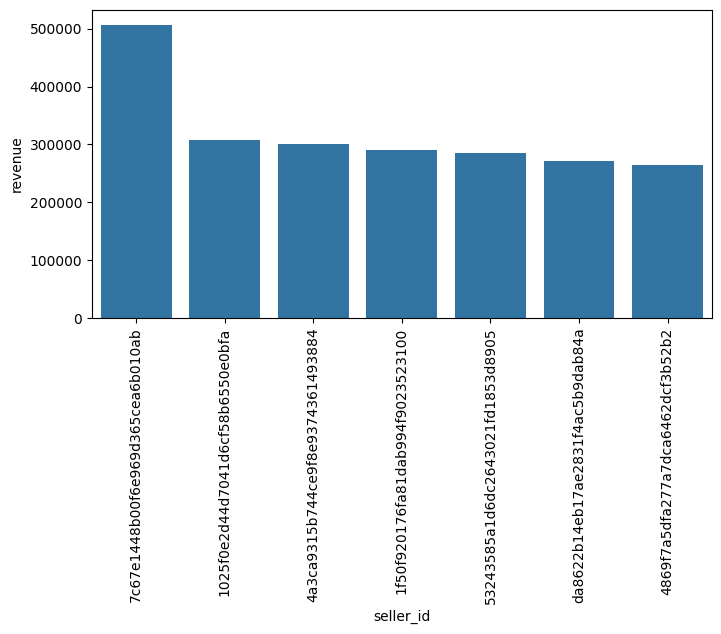

In [98]:
query = '''select *,dense_rank() over (order by revenue desc) as rn from
(SELECT order_items.seller_id,sum(payments.payment_value)
revenue
from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a
   
'''
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data ,columns=['seller_id','revenue','rank'])
df=df.head(7)
plt.figure(figsize=(8,4))
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()



## Calculate the moving average of order values for each customer over their order history.

In [106]:
query=""" select customer_id, order_purchase_timestamp, payment,
avg(payment)over(partition  by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data , columns=['customer_id','timestamp','payment','moving_avg'])
df.head(7)



,customer_id,timestamp,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
5,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
6,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006


## Calculate the year-over-year growth rate of total sales.


In [109]:
query=""" WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS year,
        ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM 
        orders 
    JOIN 
        payments ON orders.order_id = payments.order_id
    GROUP BY 
        year 
    ORDER BY 
        year
)
SELECT 
    year, 
    ((payment - LAG(payment, 1) OVER(ORDER BY year)) / 
    LAG(payment, 1) OVER(ORDER BY year)) * 100 AS percent_change
FROM 
    a;
"""

cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=['years','year-of-growth'] )
df

,years,year-of-growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


## Identify the top 3 customers who spent the most money in each year.

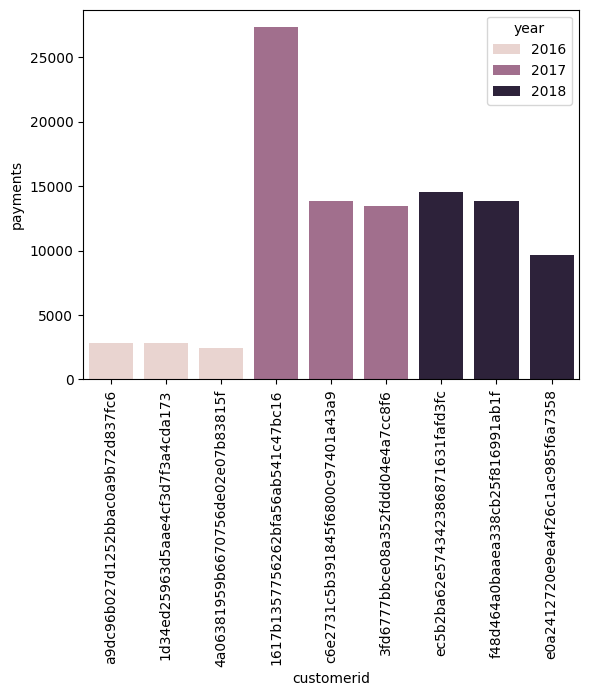

In [119]:
query='''WITH customer_spending AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS year,
        orders.customer_id,
        SUM(payments.payment_value) AS total_spent,
        RANK() OVER (
            PARTITION BY YEAR(orders.order_purchase_timestamp) 
            ORDER BY SUM(payments.payment_value) DESC
        ) AS d_rank
    FROM 
        orders
    JOIN    
        payments ON orders.order_id = payments.order_id
    GROUP BY 
        YEAR(orders.order_purchase_timestamp), orders.customer_id
)
SELECT 
    year,
    customer_id,
    total_spent,
    d_rank
FROM 
    customer_spending
WHERE 
    d_rank <= 3
ORDER BY 
    year, d_rank;

'''
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=['year','customerid','payments','rank'])
df
sns.barplot(x = "customerid", y = "payments", data = df ,hue='year') # heu= adds diffrentiation to bars by color 
plt.xticks(rotation = 90)
plt.show()

